In [8]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [9]:
words = open('../../data/names.txt','r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [10]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [11]:
import random
random.seed(42)
random.shuffle(words)

In [12]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])    
Xdev, Ydev = build_dataset(words[n1:n2])   
Xte,  Yte  = build_dataset(words[n2:])   

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [13]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [14]:
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

In [15]:
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

In [16]:
class Tanh: 
    def __call__(self, x):
        self.out = x.tanh()
        return self.out

    def parameters(self):
        return []
    

In [17]:
class Embedding: 
    
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
    
    def __call__(self, x):
        self.out = self.weight[x]
        return self.out
    
    def parameters(self):
        return [self.weight]

In [26]:
class FlattenConsecutive:
  
  def __init__(self, n):
    self.n = n
    
  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []


In [19]:
class Sequential: 
    
    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self, x):
        for layer in self.layers: 
            x = layer(x)
        return x
    
    def parameters(self):
        return [param for layer in self.layers for param in layer.parameters()]

In [20]:
torch.manual_seed(42)

In [34]:
n_embed = 24 
n_hidden = 128 


model = Sequential([
    Embedding(vocab_size, n_embed),
    FlattenConsecutive(2), Linear(n_embed * 2, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])
with torch.no_grad():
    model.layers[-1].weight *= 0.1

paramaters = model.parameters()
print(sum(p.numel() for p in paramaters))

for p in paramaters:
    p.requires_grad_()

76579


In [35]:
max_steps = 200000
batch_size = 32

loss_i = []

for step in range(max_steps):
    
    ix = torch.randint(0, len(Xtr), (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)
    # backward pass
    for p in paramaters:
        p.grad = None 
    loss.backward()

    lr = 0.1 if step < 150000 else 0.01
    
    for p in paramaters:
        p.data -= lr * p.grad
        
    if step % 10000 == 0:
        print(step, loss.item())
    loss_i.append(loss.log10().item())
    

0 3.299975633621216
10000 2.0950875282287598
20000 2.04839825630188
30000 2.023653745651245
40000 2.1077754497528076
50000 1.7538514137268066
60000 2.281090259552002
70000 2.121762752532959
80000 2.1004409790039062
90000 2.0995640754699707
100000 2.0447208881378174
110000 1.5705920457839966
120000 1.6916489601135254
130000 1.91581130027771
140000 1.7045811414718628
150000 1.9145395755767822
160000 1.3865227699279785
170000 1.4551365375518799
180000 1.4757522344589233
190000 1.7525030374526978


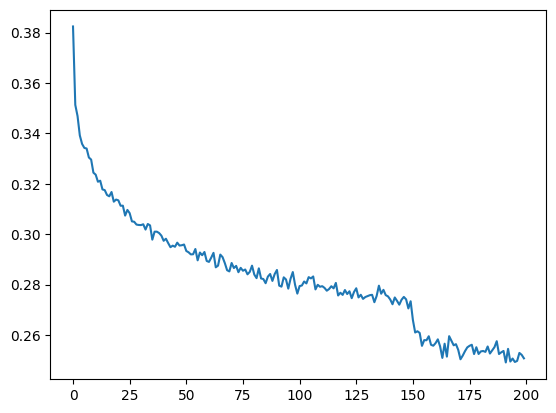

In [36]:
plt.plot(torch.tensor(loss_i).view(-1, 1000).mean(1))

In [37]:
for layer in model.layers:
    layer.training = False

In [38]:
@torch.no_grad()
def split_loss(split): 
    x, y  = {
        'train' : (Xtr, Ytr),
        'val' : (Xdev, Ydev),
        'test' : (Xte, Yte)
    }[split]
    logits = model(x)
    loss =  F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 1.7670129537582397
val 1.9925371408462524


In [39]:
for _ in range(10): 
    out = []
    context = [0] * block_size
    
    while True: 
        logits = model(torch.tensor([context]))
        prob = F.softmax(logits, dim = 1)
        ix = torch.multinomial(prob, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        
        if ix == 0: 
            break
    print(''.join(itos[ix] for ix in out))

shaman.
sarayah.
deegan.
delika.
niyana.
aarisla.
arse.
bria.
dami.
kameryn.
